In [6]:
import numpy as np, xarray as xr, pandas as pd, pandas as pd, math, time # For data handling
import cartopy.crs as ccrs, matplotlib.pyplot as plt, matplotlib as mpl  # For plotting
from utils import *                                                      # Helper functions
import dask.array as da                                                  # For faster computations
from dask.diagnostics import ProgressBar                                 # For computation feedback
from dask.distributed import Client, LocalCluster                        # For parallization
from datetime import datetime                                            # For calender handling
import s3fs                                                              # For reading bucket data
from ipywidgets import interact, interactive, fixed, widgets             # For interactive plotting
import statsmodels.formula.api as sm                                     # For regression
import xesmf                                                             # Remove?
%load_ext autoreload
%autoreload 2                                                            # To auto-reload modules

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD",                       # Key to bucket
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parallel cluster setup

In [11]:
client.close()

In [10]:
cluster = LocalCluster(n_workers=8, memory_limit='32GB') #16 is best (matches number of cores)
client = Client(cluster)

# Temperature

In [ ]:
tosBS = clip_to_region(get_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical'))

In [ ]:
tos_anomaly = time_anomaly(tosBS, 0, 12*30, -12*30, -1)
tos_anomaly.plot()

In [ ]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), model='NorESM2-LM')
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

# Sea Ice

In [ ]:
SI = clip_to_region(get_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical'))

In [ ]:
SImean = regional_average(SI, model='NorESM-LM')

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))

SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])

time_anomaly(SIMarch, 0, 12*30, -12*30, -1).plot(ax=ax[1,0])
time_anomaly(SISeptember, 0, 12*30, -12*30, -1).plot(ax=ax[1,1])

plt.show()

In [ ]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

# Chlorophyll

## Observations

In [2]:
chlos_mon_sat = clip_to_region(xr.load_dataset('OBS-ESACCI-OC.nc')) # Monthly satellite observation of Chlorophyll

In [13]:
slider_map(chlos_mon_sat.chl, datetime(1997, 10, 1), datetime(2017, 10, 1))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('1997-10', T…

## CESM2

In [7]:
chlos_cesm = get_bucket_data(variable='chlos', time_res='daily', model='CESM2', experiment='historical', chunks=365)
chlos_cesm_shifted = shift_longitude(chlos_cesm)

Request: s3://escience2022/Ada/daily/chlos_Oday_CESM2_historical_*.nc


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'chlos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [9]:
chlos_cesm_shifted

<xarray.DataArray 'chlos' (time: 60225, nlat: 384, nlon: 320)>
dask.array<open_dataset-d4bb7d54cb4889503659c0b328dcaa16chlos, shape=(60225, 384, 320), dtype=float32, chunksize=(365, 365, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nlat, nlon) float64 dask.array<chunksize=(365, 320), meta=np.ndarray>
    lon      (nlat, nlon) float64 dask.array<chunksize=(365, 320), meta=np.ndarray>
  * nlat     (nlat) int32 1 2 3 4 5 6 7 8 9 ... 377 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1 2 3 4 5 6 7 8 9 ... 313 314 315 316 317 318 319 320
  * time     (time) object 1850-01-02 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        sum of chlorophyll from all phytoplankton group concentra...
    description:    sum of chlorophyll from all phytoplankton group concentra...
    frequency:      day
    id:             chlos
    long_name:      Surface Mass Concentration of Total Phytoplankton express...
    mipTable:       Oday
    out_name:       chlos
    prov:           Oday ((isd.003))
    realm:          ocnBgchem
    standard_name:  mass_concentration_of_phytoplankton_expressed_as_chloroph...
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Mass Concentration of Total Phytoplankton express...
    type:           real
    units:          kg m-3
    variable_id:    chlos

In [12]:
areacello_cesm = get_areacello('CESM2')

Found local areacello NetCDF


In [16]:
area_cesm_clipped = clip_to_region(areacello_cesm, minlon=0, maxlon=70, minlat=65, maxlat=90).compute()

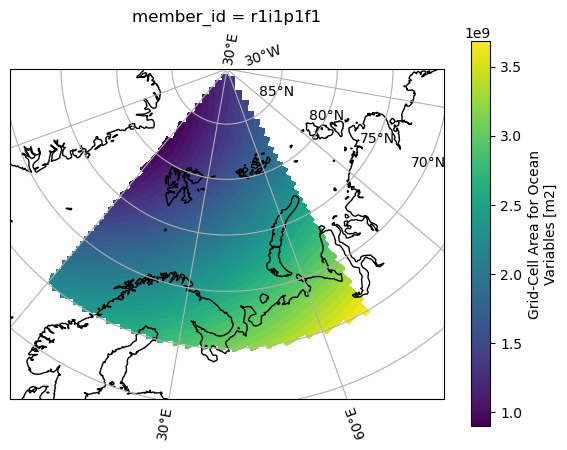

In [17]:
area_cesm_clipped.plot(ax=barentsMap(minlon=0, maxlat=90, maxlon=80, minlat=60)[1], transform=ccrs.PlateCarree(), x='lon', y='lat')

In [14]:
clipped_chlos = clip_to_region2(chlos_cesm_shifted, model='CESM2',
                                minj=math.floor(area_cesm_clipped.nlat.min()), 
                                maxj=math.ceil(area_cesm_clipped.nlat.max()), 
                                mini=math.floor(area_cesm_clipped.nlon.min()), 
                                maxi=math.ceil(area_cesm_clipped.nlon.max()))

In [18]:
with ProgressBar():
    clipped_chlos.compute()

KeyboardInterrupt: 

## NorESM2-LM

### Get data

In [3]:
# NOT NEEDED ANYMORE! ALL DAILY CHLOS READ TO FILE FOR BARENTS (april-september) Takes 15 mins to read all in if not
# start = time.time()
# chlos = get_bucket_data('chlos', time_res='daily', thing='Oday', experiment='historical')
# chlos1 = clip_to_region(chlos.chlos.isel(time=slice(0, 365*50)), minlat=65, minlon=0, maxlon=70)
# chlos2 = clip_to_region(chlos.chlos.isel(time=slice(365*50, 2 * 365*50)), minlat=65, minlon=0, maxlon=70)
# chlos3 = clip_to_region(chlos.chlos.isel(time=slice(2*365*50, -1)), minlat=65, minlon=0, maxlon=70)
# chlos_full = xr.concat([chlos1, chlos2, chlos3], dim='time')
# print(time.time() - start)

hey!
None
Request: s3://escience2022/Ada/daily/chlos_Oday_NorESM2-LM_historical_*.nc
901.5332541465759


In [4]:
chlos_noresm = xr.load_dataset('chlos_NorESM2-LM_full_try2')

In [5]:
SI_noresm = xr.load_dataarray('SI_NorESM2-LM_monthly')

In [6]:
chlos_barents = clip_to_region(chlos_noresm.chlos, minlat=75, maxlat=80, minlon=20, maxlon=60)
SI_barents = clip_to_region(SI_noresm, minlat=75, maxlat=80, minlon=20, maxlon=60)

### Sliders

In [7]:
slider_map(chlos_barents, freq='D', start=datetime(2013, 4, 1), stop=datetime(2014, 10, 1), 
           name='PC NorESM2-LM', model=True, minlat=74)

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-04-01'…

In [8]:
slider_map(SI_barents, freq='M', start=datetime(2013, 1, 1), stop=datetime(2014, 12, 1), minlat=74, 
           name='SIC NorESM2-LM', model=True, color='Blues', levels=np.linspace(0, 100, 21))

interactive(children=(SelectionSlider(description='date', layout=Layout(width='800px'), options=(('2013-01', T…

### Anomalies

In [9]:
chlos_barents_mean = regional_average(chlos_barents)
SI_barents_mean = regional_average(SI_barents)

Found local areacello NetCDF
Found local areacello NetCDF


In [10]:
chlos_anomaly = time_anomaly(chlos_barents, 0, 365*30, -365*30, -1)
SI_anomaly = time_anomaly(SI_barents, 0, 365*30, -365*30, -1)

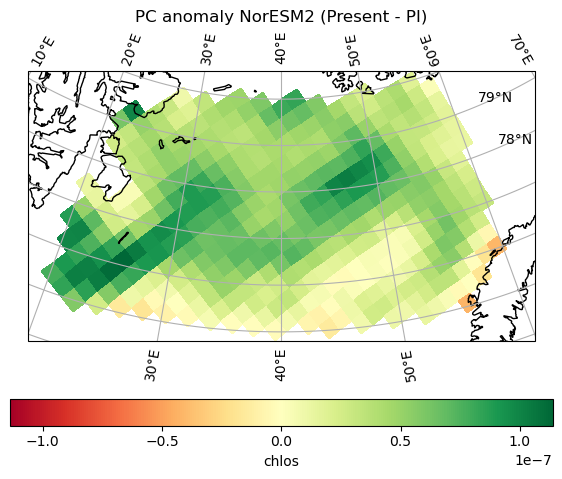

In [11]:
chlos_anomaly.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                   cmap='RdYlGn', cbar_kwargs={'location': 'bottom'})
plt.title('PC anomaly NorESM2 (Present - PI)')
plt.show()

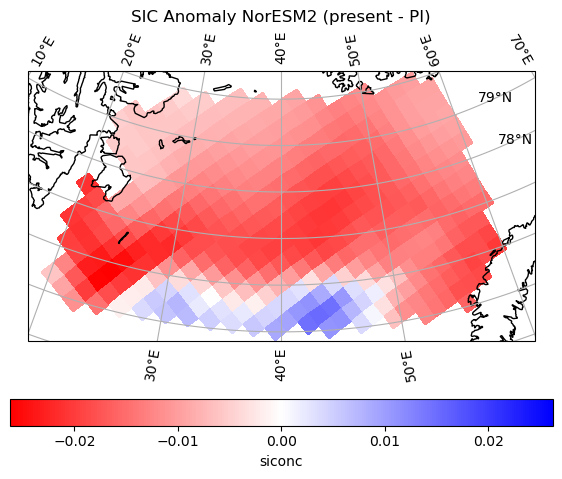

In [12]:
SI_anomaly.plot(ax=barentsMap(minlat=74)[1], transform=ccrs.PlateCarree(), x='longitude', y='latitude', 
                        cmap='bwr_r', cbar_kwargs={'location': 'bottom'})
plt.title('SIC Anomaly NorESM2 (present - PI)')
plt.show()

### Peaks

##### Each cell individually

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/jovyan/escience-2022/Tjaernoe2022-group6/notebooks/Stian/utils.py:129: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()


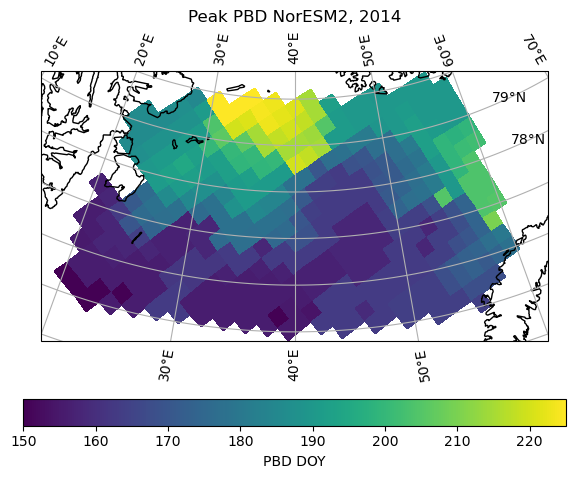

In [201]:
peaks_eachcell = find_peak_dates(chlos_barents)
peaks_eachcell = xr.DataArray(df['dayofyear'].values.reshape(shape), dims=['time', 'j', 'i'], 
                  coords=dict(longitude=(["j", "i"], chlos_barents.longitude.values), 
                              latitude=(["j", "i"], chlos_barents.latitude.values), 
                              time=np.arange(1850, 2015)))
peaks_eachcell.isel(time=-1).plot(ax=barentsMap(minlat=74)[1], x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                                  cbar_kwargs={'location':'bottom', 'label':'PBD DOY'})
plt.title('Peak PBD NorESM2, 2014')
plt.show()

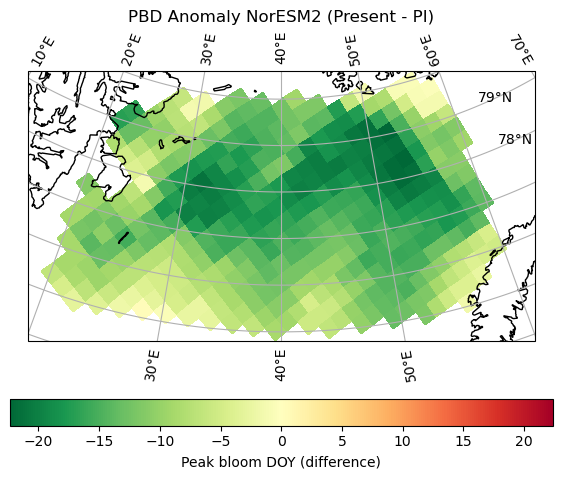

In [200]:
peaks_eachcell_anomaly = time_anomaly(peaks_eachcell, 0, 30, -30, -1)
peaks_eachcell_anomaly.plot(ax=barentsMap(minlat=74)[1], x='longitude', y='latitude', transform=ccrs.PlateCarree(), 
                            cmap='RdYlGn_r', cbar_kwargs={'location':'bottom', 'label':'Peak bloom DOY (difference)'})
plt.title('PBD Anomaly NorESM2 (Present - PI)')
plt.show()

In [173]:
# _dat = chlos_barents.copy()
# _dat['time']  = _dat.time.to_dataframe().index.to_datetimeindex()
# _dat = _dat.groupby('time.year')
# peak_dates_each_cell = [_dat[year].idxmax(dim='time').values for year in _dat.groups.keys()]
# shape = np.shape(peak_dates_each_cell)

# df = xr.DataArray(peak_dates_each_cell).to_dataframe('date')

# df['dayofyear'] = pd.to_datetime(df['date']).dt.dayofyear
# df['year'] = pd.to_datetime(df['date']).dt.year
# #plt.plot(df['year'], df['dayofyear'])
# da = xr.DataArray(df['dayofyear'].values.reshape(shape), dims=['years', 'j', 'i'], 
#                   coords=dict(longitude=(["j", "i"], chlos_barents.longitude.values), 
#                               latitude=(["j", "i"], chlos_barents.latitude.values), 
#                               time=time))

##### Whole Barents Mean

In [209]:
peak_dates = find_peak_dates(chlos_barents_mean)

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/home/jovyan/escience-2022/Tjaernoe2022-group6/notebooks/Stian/utils.py:219: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7ff93eae6f70>>


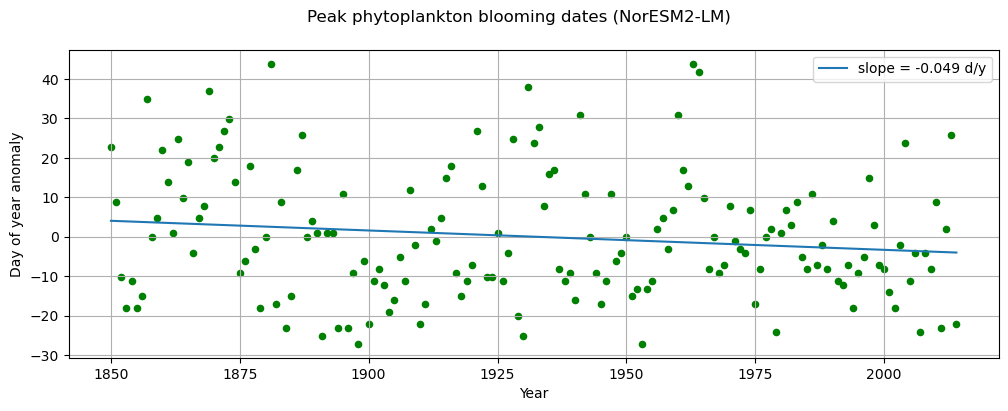

In [213]:
scatter_dates(peak_dates, last_n_years=0)

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7ff957967130>>


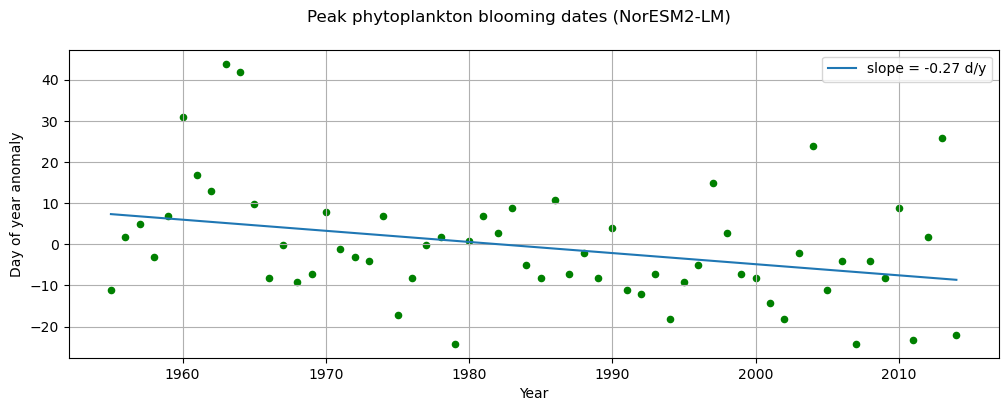

In [212]:
scatter_dates(peak_dates, last_n_years=60)

### Dependence on Sea Ice Concentration

In [97]:
SI_yearly_mean = SI_barents_mean.groupby('time.year').mean(dim='time')

df = pd.DataFrame([SI_yearly_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158d723d00>>


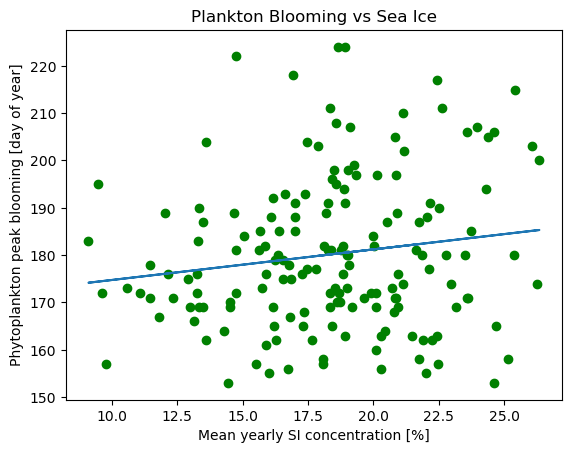

In [109]:
plt.xlabel('Mean yearly SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_yearly_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_yearly_mean.values, a * SI_yearly_mean.values + b)

In [96]:
SI_june_mean = SI_barents_mean.groupby('time.month')[5]
df = pd.DataFrame([SI_june_mean.squeeze().values, peak_dates['dayofyear'].values]).T
df.columns =['SI', 'doy']
a, b = regression(df, 'SI', 'doy')

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x7f158be8f580>>


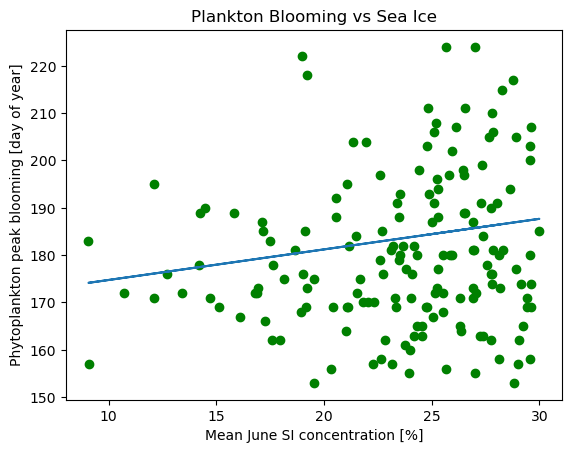

In [108]:
plt.xlabel('Mean June SI concentration [%]')
plt.ylabel('Phytoplankton peak blooming [day of year]')
plt.title('Plankton Blooming vs Sea Ice')
plt.scatter(SI_june_mean.values, peak_dates['dayofyear'].values, color='g')
plt.plot(SI_june_mean.values, a * SI_march_mean.values + b)

### All years visualized

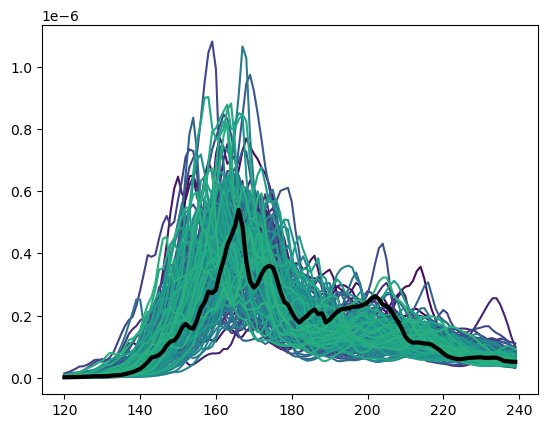

In [89]:
fig, ax = plt.subplots()
#average_yearly_cycle = chlos_daily_mean.chlos.groupby('time.dayofyear').mean()

cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[::int(cmap.N/165)]
#cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(1850, 2015)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

chlos_daily_mean_grouped = chlos_daily_mean.chlos.groupby('time.year')
[ax.plot(np.arange(120, 120+30*4), chlos_daily_mean_grouped[year].isel(time=slice(120, 120+30*4)), color=cmaplist[year-1850]) for year in range(1850, 2014)]

ax.plot(np.arange(120, 120+30*4), chlos_daily_mean.chlos.isel(time=slice(120, 120+30*4)), linewidth=3, color='k')
#ax.legend()
plt.show()

Do we see a shift in the peak phytoplankton blooming date in the Barentz sea in connection to the sea ice retreat?

In [11]:
start = time.time()
with ProgressBar():
    chlos_daily_mean.compute()
print(time.time() - start)

0.027305126190185547


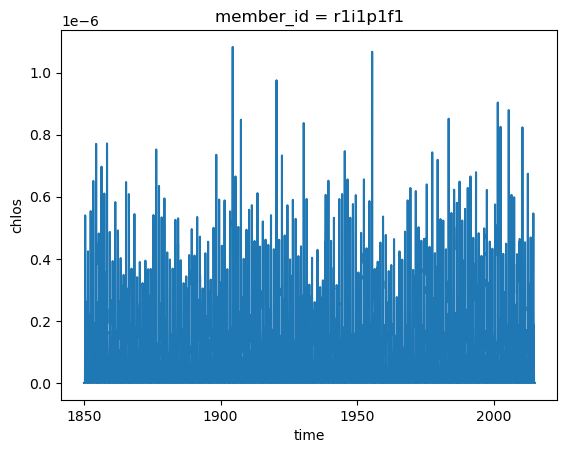

In [18]:
chlos_daily_mean.chlos.plot()

### Notes

månedlig noresm chlos for å se peak, plotte oppå /OBS-ESACCI-OC/

For NorESM2 chlorophyll, time by 10 to get total mass when integrating for surface layer

- Get daily observations

- Repeat for CESM

- Repeat for NorESM-SSP385